In [1]:
import numpy as np
import itertools as it

from helpers import *

from tqdm import tqdm
from implementations import *
from cross_validation import build_k_fold_sets, cross_validation_ridge
from feature_eng import *
from data_cleaning import replace_invalid
from plots import display_features
from params_extracting import build_combinations

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
y, x_brute_train, _ = load_csv_data("../data/train.csv")

In [3]:
_, x_brute_test, indices_test = load_csv_data("../data/test.csv")

In [4]:
y.shape, x_brute_train.shape, x_brute_test.shape

((250000,), (250000, 30), (568238, 30))

In [5]:
train_size = x_brute_train.shape[0]
test_size = x_brute_test.shape[0]

train_size, test_size

(250000, 568238)

In [6]:
x_brute = np.concatenate((x_brute_train, x_brute_test))
x_brute.shape

(818238, 30)

In [7]:
features_name = ["DER_mass_MMC","DER_mass_transverse_met_lep","DER_mass_vis","DER_pt_h","DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_deltar_tau_lep","DER_pt_tot","DER_sum_pt","DER_pt_ratio_lep_tau","DER_met_phi_centrality","DER_lep_eta_centrality","PRI_tau_pt","PRI_tau_eta","PRI_tau_phi","PRI_lep_pt","PRI_lep_eta","PRI_lep_phi","PRI_met","PRI_met_phi","PRI_met_sumet","PRI_jet_num","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi","PRI_jet_all_pt"]

In [8]:
DER_features = [i for i, f in enumerate(features_name) if ("DER_" in f)]

DER_features

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [9]:
PHI_features = [i for i, f in enumerate(features_name) if ("_phi" in f) and ("_phi_" not in f)]

PHI_features

[15, 18, 20, 25, 28]

# Data Cleaning

In [10]:
mask_invalid = x_brute != -999.0

Features with invalid values

In [11]:
features_with_invalid = [(i, num / (train_size + test_size) * 100)  for i, num in enumerate((~mask_invalid).sum(axis=0).tolist()) if num > 0]
features_with_invalid

[(0, 15.228087671313236),
 (4, 70.91494161845331),
 (5, 70.91494161845331),
 (6, 70.91494161845331),
 (12, 70.91494161845331),
 (23, 40.00926380832961),
 (24, 40.00926380832961),
 (25, 40.00926380832961),
 (26, 70.91494161845331),
 (27, 70.91494161845331),
 (28, 70.91494161845331)]

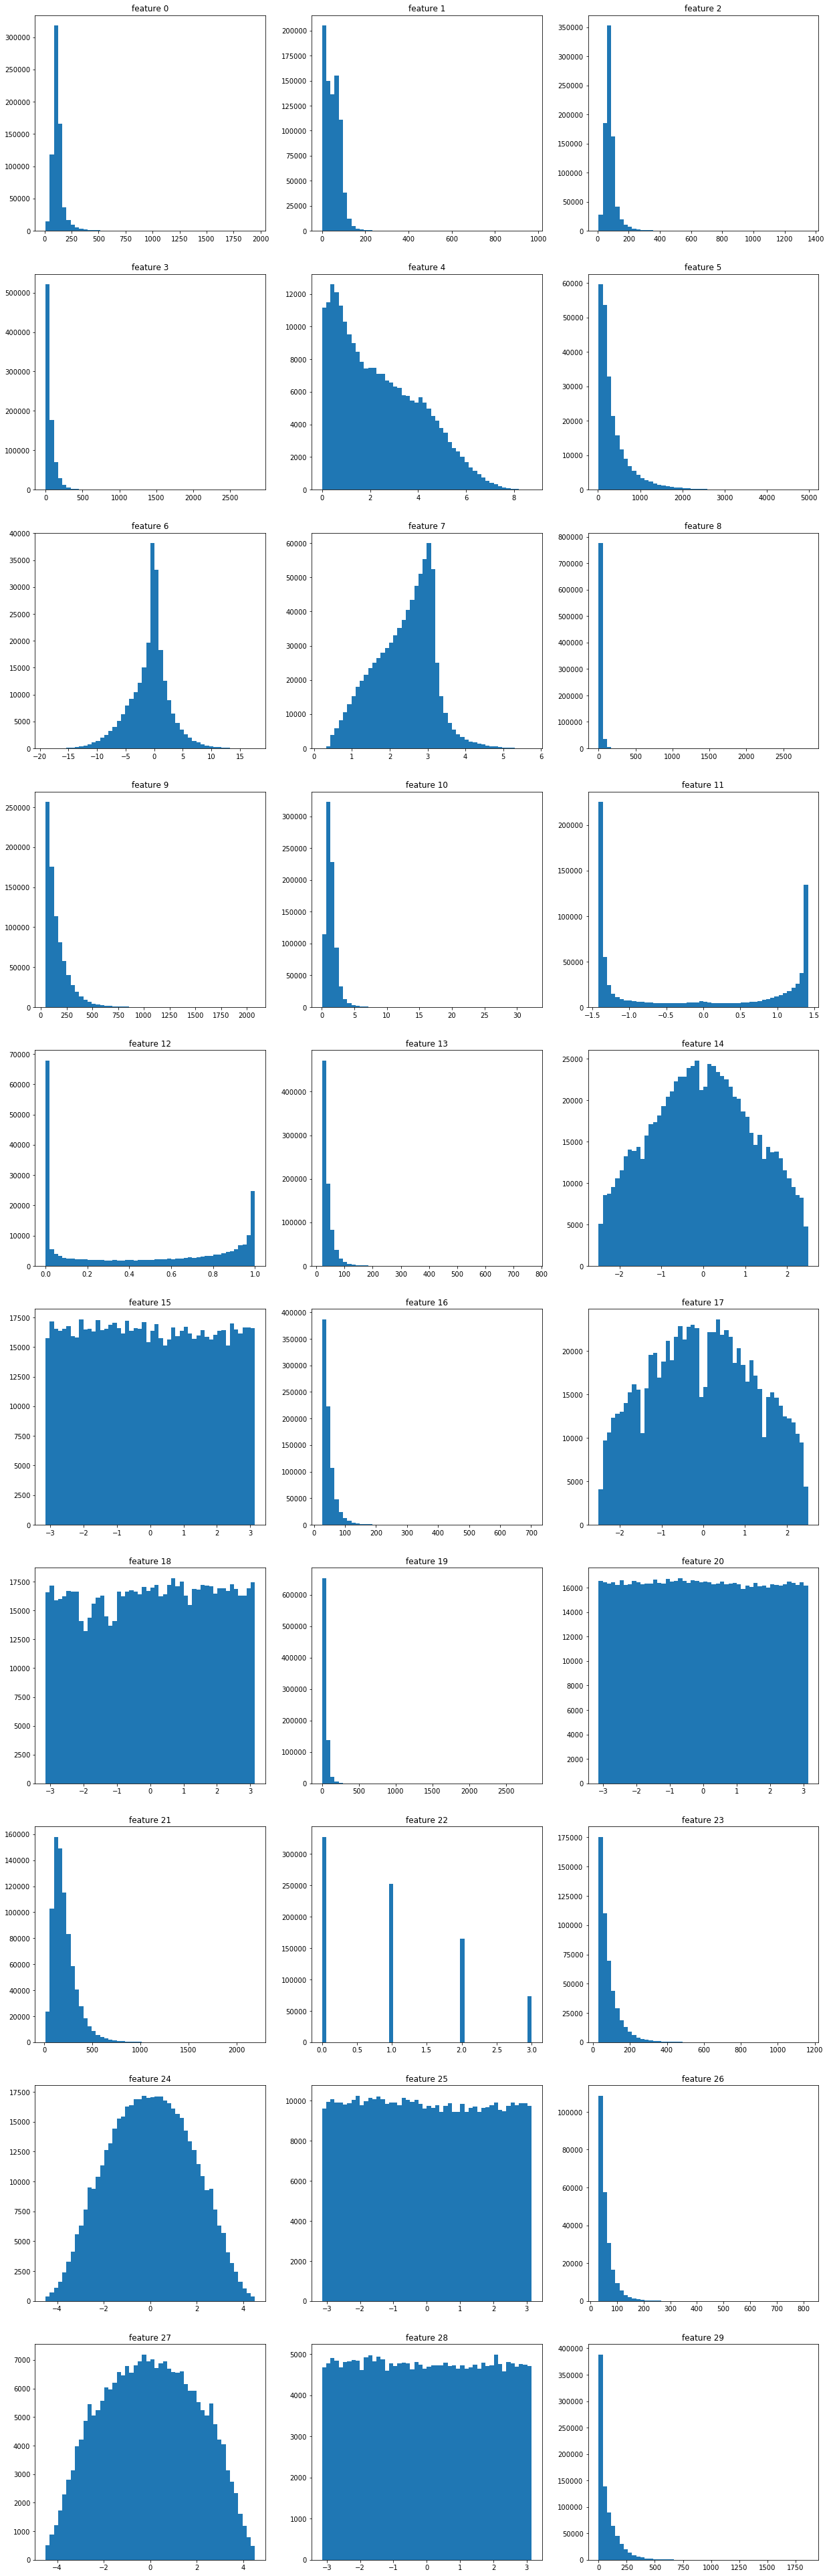

In [12]:
display_features(x_brute, mask_invalid, bins=50)

# Conditioning

In [13]:
def verify_masks(masks):
    total = 0
    for mask in masks:
        num = mask.sum()
        print(num)
        total += num
    assert total == x_brute.shape[0]
    return len(masks)

## Conditioning on invalid features

In [14]:
def mask_feat_i_invalid(i):
    return [
    x_brute[:, i] == -999.0,
    x_brute[:, i] != -999.0
]

In [15]:
verify_masks(mask_feat_i_invalid(4))

580253
237985


2

## Conditioning on feature #3

In [16]:
limit = 3
x_brute_3 = x_brute[:, 3] - x_brute[:, 3].min() + 1
masks_feat_3 = [
    np.log(x_brute_3) <= limit,
    np.log(x_brute_3) > limit
]

verify_masks(masks_feat_3)

227115
591123


2

## Conditioning on feature #8

In [17]:
limit = 2.7
x_brute_8 = x_brute[:, 8] - x_brute[:, 8].min() + 1
masks_feat_8 = [
    np.log(x_brute_8) <= limit,
    np.log(x_brute_8) > limit
]

verify_masks(masks_feat_8)

418233
400005


2

## Conditioning on feature #22
feature 22 has 4 different values (0, 1, 2, 3)

In [18]:
feature_22_values = np.unique(x_brute[:, 22]).tolist()
feature_22_values

[0.0, 1.0, 2.0, 3.0]

In [19]:
x_brute_22 = x_brute[:, 22]
masks_feat_22 = [
    x_brute_22 == 0,
    x_brute_22 == 1,
    x_brute_22 > 1
]

verify_masks(masks_feat_22)

327371
252882
237985


3

## Conditioning on feature #29
feature 29 is 0 (40%) or 30+

In [20]:
x_brute_29 = x_brute[:, 29]
masks_feat_29 = [
    x_brute_29 == 0,
    x_brute_29 != 0
]


verify_masks(masks_feat_29)

327371
490867


2

## Masks choosen


In [21]:
data_masks = []
for mask_i in mask_feat_i_invalid(4):#masks_feat_8:
    for mask_j in  mask_feat_i_invalid(23):#masks_feat_22:
        mask = mask_i & mask_j
        if mask.sum() > 0:
            data_masks.append(mask)
        
verify_masks(data_masks)

327371
252882
237985


3

In [22]:
feature_masks = [x_brute[m].std(axis=0) != 0 for m in data_masks]

In [23]:
x_replaced_invalid = replace_invalid(x_brute, mask_invalid, replace_by="mf")
xs_replace_invalid = [x_replaced_invalid[mask] for mask in data_masks]

[x.shape for x in xs_replace_invalid]

[(327371, 30), (252882, 30), (237985, 30)]

In [24]:
xs_cleaned = [x[:, m] for x, m in zip(xs_replace_invalid, feature_masks)]

[x.shape for x in xs_cleaned]

[(327371, 18), (252882, 22), (237985, 30)]

Angles!

In [25]:
mask_phi_features = range_mask(30, PHI_features)

In [26]:
xs_angles = [x[:, mask_phi_features[mask]] for x, mask in zip(xs_cleaned, feature_masks)]

[x.shape for x in xs_angles]

[(327371, 3), (252882, 4), (237985, 5)]

# Features Engineering

## Angle features (not used)

### Features with functions (cos, tan) for angles

In [27]:
cos_features = [np.cos(x) for x in xs_angles]

[f.shape for f in cos_features]

[(327371, 3), (252882, 4), (237985, 5)]

In [28]:
tan_features = [np.tan(x) for x in xs_angles]

[f.shape for f in tan_features]

[(327371, 3), (252882, 4), (237985, 5)]

In [29]:
angles_features = [np.concatenate((cos_features[i], tan_features[i]), axis=1) for i in range(len(data_masks))]

[f.shape for f in angles_features]

[(327371, 6), (252882, 8), (237985, 10)]

## Features with log

In [30]:
xs_log = []

for x in xs_cleaned:
    mask_negative_values = ~np.any(x <= 0, axis=0)
    non_negative_features = x[:, mask_negative_values]

    xs_log.append(np.log(non_negative_features))
    
[f.shape for f in xs_log]

[(327371, 10), (252882, 11), (237985, 16)]

In [31]:
xs_inv_log = []

for x in xs_cleaned:
    mask_negative_values = ~np.any(x <= 0, axis=0)
    non_negative_features = x[:, mask_negative_values]

    xs_log.append(np.log(1 / (1 + non_negative_features)))
    
[f.shape for f in xs_log]

[(327371, 10),
 (252882, 11),
 (237985, 16),
 (327371, 10),
 (252882, 11),
 (237985, 16)]

## Polynomial features

poly_with_both = [i for i in range(30) if i not in phi_features]

poly_with_lin = [4, 6, 7, 11, 14, 17, 24, 27, 28]
poly_with_log = [0, 1, 2, 3, 5, 8, 9, 10, 13, 16, 19, 21, 23, 26, 29]

lin_mask = range_mask(30, lin_mask)
log_mask = range_mask(30, log_mask)

lin_mask.shape, log_mask.shape

In [32]:
xs_mix = [np.concatenate((x1, x2), axis=1) for x1, x2 in zip(xs_cleaned, xs_log)]

[f.shape for f in xs_mix]

[(327371, 28), (252882, 33), (237985, 46)]

In [34]:
# hardcoded (from param_tuning)
mix_to_mask = [
    [4,7,20,21],
    [4, 11, 25],
    [9, 10, 15, 23, 38],
    [0, 1, 7, 8, 12, 15, 22, 25, 26, 28, 29],
    [9, 12, 23, 31],
    [2, 4, 24, 25, 27, 29, 37, 44]
]

#for i in range(len(mix_to_mask)):
#    mix_to_mask[i].extend(list(range(13)))


#xs_mix_best_only = [x[:, ~range_mask(x.shape[1], m)] for x, m in zip(xs_mix, mix_to_mask)]

#[f.shape for f in xs_mix_best_only]

## Standardization of the data

In [35]:
xs_standardized = [standardize(x) for x in xs_mix]

[x.shape for x in xs_standardized]

[(327371, 28), (252882, 33), (237985, 46)]

In [36]:
#degrees =  [10, 10, 11, 8, 11, 10]
degrees =  [9, 9, 10, 7, 10, 9]

In [37]:
poly_features = [build_poly(x, degree) for x, degree in tqdm(zip(xs_standardized, degrees), ncols=100)]

[f.shape for f in poly_features]

3it [00:14,  4.80s/it]


[(327371, 280), (252882, 330), (237985, 506)]

## Indicator features

### feature value is invalid (1) or not (0)

all_features_with_invalid = indicator_features(mask_invalid)
features_with_invalid = []
for mask in data_masks:
    f_with_invalid = all_features_with_invalid[mask]
    mask = f_with_invalid.std(axis=0) > 0
    features_with_invalid.append(f_with_invalid[:, mask])

[f.shape for f in features_with_invalid]

## Combinations of features

In [38]:
def all_combinations_of(xs, fn, combs):
    combinations = []
    for i, pairs in tqdm(list(enumerate(combs)), ncols=100):
        combinations.append(combinations_of(xs[i], fn, pairs))
    return combinations

def combinations_of(x, fn, pairs):
    if len(pairs) > 0:
        combinations = [fn(x[:, int(a)], x[:, int(b)]).reshape((x.shape[0], 1)) for a, b in pairs]
        return np.concatenate(combinations, axis=1)
    return np.array([])

In [39]:
functions = {
    "mult": np.multiply,
    "abs_sub": lambda a,b: np.abs(a - b),
    #"div": np.divide
}

In [40]:
def combinations(n, m, with_repetition=False, with_itself=False):
    return [(i, j) for i in range(n) for j in range(m) if (with_repetition or j >= i) and (with_itself or j != i)]

In [41]:
features_combs = {}
for fn_name in functions.keys():
    fn_combinations = [combinations(xs_standardized[i].shape[1], xs_standardized[i].shape[1]) for i in range(3)] #build_combinations(fn_name, 0.1)
    print(fn_name + ": {}".format([len(c) for c in fn_combinations]))
    features_combs[fn_name] = all_combinations_of(xs_standardized, functions[fn_name], fn_combinations)

mult: [378, 528, 1035]


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:36<00:00, 12.27s/it]


abs_sub: [378, 528, 1035]


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.85s/it]


## Concat all features

In [42]:
all_features = zip(
    poly_features,
    features_combs["mult"],
    features_combs["abs_sub"]
)

features = [np.concatenate([f for f in list(fs) if len(f) > 0], axis=1) for fs in tqdm(list(all_features), ncols=100)]

[f.shape for f in features]

100%|█████████████████████████████████████████████████████████████████| 3/3 [01:51<00:00, 37.05s/it]


[(327371, 1036), (252882, 1386), (237985, 2576)]

# Separating Training and Test data

In [43]:
xs_train, xs_test = separate_train(features, train_size, data_masks)

[(tr.shape, te.shape) for tr, te in zip(xs_train, xs_test)]

[((99913, 1036), (227458, 1036)),
 ((77544, 1386), (175338, 1386)),
 ((72543, 2576), (165442, 2576))]

In [44]:
ys = [y[mask[:train_size]] for mask in data_masks]

[y.shape for y in ys]

[(99913,), (77544,), (72543,)]

# Cross validation

In [48]:
k_fold = 4
iters = 1

lambdas = [1e-04, 5e-04, 5e-04, 1e-03, 1e-04, 1e-03 ]
#lambdas = [1e-02]*6

xs_scores = []
for y_tr, x_tr, lambda_ in zip(ys, xs_train, lambdas):
    
    scores = np.array([score for score in cross_validation_ridge(y_tr, x_tr, k_fold, lambda_) for _ in range(iters)])
    
    xs_scores.append(scores.mean() * x_tr.shape[0] / train_size)
    
    print("Test Error Mean = {}".format(scores.mean() * 100))
    print("Test Error St.D = {}".format(scores.std() * 100))
    
np_xs_losses = np.array(xs_scores)
print("Final Test Error = {}".format(np_xs_losses.sum() * 100))


Test Error Mean = 84.95375930819121
Test Error St.D = 0.09209734857008237
Test Error Mean = 81.51759001341173
Test Error St.D = 0.11459228253132821


MemoryError: 

# Submission

In [49]:
def pred_ridge_with_conditioning(ys, xs_train, xs_test, lambdas):
    y_sub = np.zeros(np.sum([x.shape[0] for x in xs_test]))
    for y, x_tr, x_te, lambda_, mask in zip(ys, xs_train, xs_test, lambdas, data_masks):
        w = ridge_regression(y, x_tr, lambda_)
        y_sub_part = predict_labels(w, x_te)
        y_sub[mask[train_size:]] = y_sub_part
    return y_sub

In [ ]:
#rigde
y_submission = pred_ridge_with_conditioning(ys, xs_train, xs_test, lambdas)

#logistic
# w_submission, _ = logistic_regression(y_train, x_train, initial_w, max_iters, gamma)
# y_submission = predict_labels(w, x_test)

In [ ]:
create_csv_submission(indices_test, y_submission, "submissions/pred20.csv")